In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pympc.models.boxatlas_parametric import BoxAtlas, MovingLimb, FixedLimb, Trajectory
from pympc.control import MPCHybridController
from pympc.feasible_set_library import FeasibleSetLibrary, load_library
from pympc.geometry.polytope import Polytope
import pympc.plot as mpc_plt

# Construction of Box-Atlas

Robot's limbs

In [3]:
from pympc.models.boxatlas_parameters import dynamics
penetration = dynamics['mass'] * dynamics['gravity'] / dynamics['normal_stiffness']

# right hand
A_rh = {
    'not_in_contact': np.array([[-1., 0.],[0., -1.]]),
    'in_contact': np.array([[1., 0.],[-1., 0.],[0., -1.]]),
}
b_rh = {
    'not_in_contact': np.array([[.4],[.5]]),
    'in_contact': np.array([[-.4],[.4+penetration],[.5]]),
}
contact_surfaces_rh = {
    'not_in_contact': None,
    'in_contact': 0,
}
q_rh = np.array([[-.3], [.0]])
parametric_wall_distance = {
    'label': 'wall_distance_rh',
    'not_in_contact': {'index': [0], 'coefficient': [1.]},
    'in_contact': {'index': [0, 1], 'coefficient': [-1., 1.]},
    'min': -.05,
    'max': .05,
} # if positive moves the wall away from the body
parameters_rh = [parametric_wall_distance]
rh = MovingLimb(A_rh, b_rh, contact_surfaces_rh, q_rh, parameters=parameters_rh)

# left foot
A_lf = {
    'not_in_contact': np.array([[0., -1.]]),
    'in_contact': np.array([[0., 1.],[0., -1.]]),
}
b_lf = {
    'not_in_contact': np.array([[.5]]),
    'in_contact': np.array([[-.5],[.5+2.*penetration]]),
}
contact_surfaces_lf = {
    'not_in_contact': None,
    'in_contact': 0,
}
q_lf = np.array([[.2], [-.5 - penetration / 2.]])
lf = MovingLimb(A_lf, b_lf, contact_surfaces_lf, q_lf)

# right foot
A_rf = {
    'not_in_contact': np.array([[-1., 0.],[0., -1.]]),
    'in_contact': np.array([[0., 1.],[-1., 0.],[0., -1.]]),
}
b_rf = {
    'not_in_contact': np.array([[.5],[.5]]),
    'in_contact': np.array([[-.5],[.5],[.5+2.*penetration]]),
}
contact_surfaces_rf = {
    'not_in_contact': None,
    'in_contact': 0,
}
q_rf = np.array([[-.2], [-.5 - penetration / 2.]])
rf = MovingLimb(A_rf, b_rf, contact_surfaces_rf, q_rf)

Assemble robot

In [4]:
limbs = { 'moving': {'rh': rh, 'lf': lf, 'rf': rf}, 'fixed': {} }
nominal_mode = {'lf': 'in_contact', 'rf': 'in_contact', 'rh': 'not_in_contact'}
forbidden_modes = [{'lf': 'not_in_contact', 'rf': 'not_in_contact'}]
box_atlas = BoxAtlas(limbs, nominal_mode, forbidden_modes)

Computation of Maximal Invariant Constraint-Admissible Set started.
Determinedness index: 6, Convergence index: 0.0, Number of facets: 217.                              
Maximal Invariant Constraint-Admissible Set found.
Removing redundant facets ... minimal facets are 63.
Changed value of parameter TimeLimit to 600.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Parameter FeasibilityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter NumericFocus unchanged
   Value: 0  Min: 0  Max: 3  Default: 0
Parameter OptimalityTol unchanged
   Value: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Parameter MIPGap unchanged
   Value: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Parameter IntFeasTol unchanged
   Value: 1e-05  Min: 1e-09  Max: 0.1  Default: 1e-05
Parameter MIPFocus unchanged
   Value: 0  Min: 0  Max: 3  Default: 0
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


Print state, input, and modes

In [5]:
box_atlas.print_state_labels()
box_atlas.print_input_labels()
box_atlas.print_modes()


Box-Atlas states:
0: wall_distance_rh
1: qlfx
2: qlfy
3: qrfx
4: qrfy
5: qrhx
6: qrhy
7: qbx
8: qby
9: tb
10: vbx
11: vby
12: ob

Box-Atlas inputs:
0: vlfx
1: vlfy
2: vrfx
3: vrfy
4: vrhx
5: vrhy

Box-atlas modes:
0: {'lf': 'not_in_contact', 'rf': 'in_contact', 'rh': 'not_in_contact'}
1: {'lf': 'not_in_contact', 'rf': 'in_contact', 'rh': 'in_contact'}
2: {'lf': 'in_contact', 'rf': 'not_in_contact', 'rh': 'not_in_contact'}
3: {'lf': 'in_contact', 'rf': 'not_in_contact', 'rh': 'in_contact'}
4: {'lf': 'in_contact', 'rf': 'in_contact', 'rh': 'not_in_contact'}
5: {'lf': 'in_contact', 'rf': 'in_contact', 'rh': 'in_contact'}


# Hybrid MPC

In [6]:
x_0 = np.zeros((box_atlas.n_x, 1))
x_0[10,0] = -1.5
u, x, ss = box_atlas.controller.feedforward(x_0)[0:3]

Optimize a model with 5618 rows, 1043 columns and 23123 nonzeros
Model has 297 quadratic objective terms
Model has 10 SOS constraints
Variable types: 983 continuous, 60 integer (60 binary)
Coefficient statistics:
  Matrix range     [8e-07, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-05, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 5e+00]
Presolve removed 2440 rows and 116 columns
Presolve time: 0.06s
Presolved: 3178 rows, 927 columns, 17073 nonzeros
Presolved model has 274 quadratic objective terms
Variable types: 873 continuous, 54 integer (54 binary)

Root relaxation: objective 3.347506e+00, 5631 iterations, 0.26 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.34751    0   26          -    3.34751      -     -    0s
H    0     0                       3.8522210    3.34751  13.1%     -    0s
     0     0    3.34751 

In [7]:
prog = box_atlas.controller.condense_program(ss)
lhs = prog.C_u
rhs = prog.C + prog.C_x.dot(x_0)

In [18]:
from pympc.geometry.chebyshev_center import chebyshev_center
prog = box_atlas.controller.condense_program(ss)
center, radius = chebyshev_center(lhs, rhs)

0.0039279460907


In [19]:
from pympc.optimization.gurobi import linear_program
sol  = linear_program(np.zeros((60,1)), lhs, rhs)

0.00385999679565


In [28]:
# z≥0,ATz=0,bTz<0
from pympc.optimization.gurobi import linear_program
from pympc.algebra import nullspace_basis
Z = nullspace_basis(lhs.T)
lhs_cone = np.vstack((-Z, rhs.T.dot(Z)))
rhs_cone = np.vstack((np.zeros((Z.shape[0],1)), -np.ones((1,1))))
sol  = linear_program(np.zeros((Z.shape[1],1)), lhs_cone, rhs_cone)
#print sol.argmin

0.61999297142


0.00414705276489
0.0
0.0240049362183


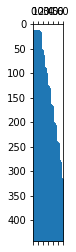

In [35]:
sol  = linear_program(np.zeros((60,1)), lhs, rhs)
print sol.min
from scipy import linalg
r, q = linalg.rq(prog.C_u)
q_inv = np.linalg.inv(q)
from pympc.algebra import clean_matrix
sol  = linear_program(np.zeros((60,1)), clean_matrix(r), rhs)
import scipy
plt.spy(scipy.sparse.csr_matrix(prog.C_u))
plt.show()

Closed-loop system simulation of the MPC controller

In [ ]:
N_sim = 30
u = []
# ['wall_distance_rh', 'qlfx', 'qlfy', 'qrfx', 'qrfy', 'qrhx', 'qrhy', 'qbx', 'qby', 'tb', 'vbx', 'vby', 'ob']
x_0 = np.zeros((box_atlas.n_x, 1))
x_0[1,0] = .2
x_0[3,0] = .2
x = [x_0]
u_ws = None
x_ws = None
ss_ws = None
nominal_mode = box_atlas.get_mode_index(box_atlas.nominal_mode)
for k in range(N_sim):
    u_k, x_k, ss_k = box_atlas.controller.feedforward(x[k], u_ws, x_ws, ss_ws)[0:3]
    print 'Time step ' + str(k) + ': ' + str(ss_k) + '.'
    u_ws = u_k[1:] + [box_atlas.K.dot(x_k[-1])]
    x_ws = x_k[1:] + [box_atlas.pwa_system.simulate(x_k[-1], [u_ws[-1]])[0][1]]
    ss_ws = ss_k[1:] + (nominal_mode,)
    x_next = box_atlas.pwa_system.simulate(x[k], [u_k[0]])[0][1]
    # print 'Planner-simulator missmatch:', np.linalg.norm(x_next - x_k[1])
    u.append(u_k[0])
    x.append(x_next)
# traj_miqp = Trajectory(x, u, box_atlas.Q, box_atlas.R, box_atlas.P)
# np.save('box_atlas_tajectory_miqp_lh', traj_miqp)

Visualization of the simulation with Director

In [ ]:
from pympc.models.boxatlas_parameters import dynamics
box_atlas.visualize(x[0])
time.sleep(10 * dynamics['sampling_time'])
for x_t in x:
    box_atlas.visualize(x_t)
    time.sleep(dynamics['sampling_time'])

In [ ]:
box_atlas.print_mode_sequence(ss)

# Approximate Hybrid MPC

Initialization of the library

In [ ]:
library = FeasibleSetLibrary(box_atlas.controller)
samples_so_far = 0
# library = load_library('library_box_atlas_' + str(samples_so_far))

Coverage

In [ ]:
sample_step = 100
n_steps = 100
for i in range(n_steps):
    n = samples_so_far + (i+1)*sample_step
    library.sample_policy(sample_step, box_atlas.is_inside_a_domain)
    print(str(n) + ' samples added to the library.')
    library.save('library_box_atlas_moving_feet_' + str(n))

Shifted switching sequences

In [ ]:
library.add_shifted_switching_sequences(nominal_mode)

Closed-loop system simulation of the approximate MPC controller

In [ ]:
u = []
x = [x_0]
ss = []
ss_feasible = None
for k in range(N_sim):
    print 'Time step ' + str(k) + '.'
    u_k, ss_k = library.feedback(x[k], ss_feasible, max_qp=10)
    u.append(u_k)
    x_next = box_atlas.pwa_system.simulate(x[k], [u_k])[0][1]
    x.append(x_next)
    ss.append(ss_k)
    ss_feasible = ss_k[1:] + (nominal_mode,)
traj_lib = Trajectory(x, u, box_atlas.Q, box_atlas.R, box_atlas.P)
#np.save('box_atlas_tajectory', traj_lib)